Transcription of Nicolo's script in Python

In [1]:
#Libraries and functions
%pylab notebook
from cmath import log,exp,sqrt
from numpy import sign
from scipy.special import exp1 

Populating the interactive namespace from numpy and matplotlib


In [2]:
def stab_diagramLHC_diffFD(gamma,epsnormx,epsnormy,plane, a,current_octF,current_octD,distribution):

# computes the stability diagram for the LHC (from the octupoles)
# TO BE FULLY CHECKED
#
# Input parameters:
# - gamma: relativistic mass factor of the beam,
# - epsnorm: normalized emittance (e.g. 3.75e-6 m at 7TeV),
# - a: octupole matrix as [axxF, axxD; ayyF, ayyD; axyF, axyD];
# - current_octF: current in the focusing octupoles (max is supposed to be 550A at 7TeV i.e.  gamma=7.4605e+03),
# - current_octD: current in the defocusing octupoles (max is supposed to be 550A at 7TeV i.e.  gamma=7.4605e+03)
# (most beneficial situation when sign(current_octF)=-sign(current_octD) )

# In output:
# - stabx, staby: two columns : stability diagram (i.e. Re(DeltaQ) vs. -Im(DeltaQ) )


# from Elias Metral's Mathematica notebook "StabilityDiagramsForNicolas.nb",
# June 10th, 2010.

#Ported to Python on June 17th,2016

    current_max=550; # at 7 TeV

    beta=sqrt(1-1/gamma**2); # relativistic velocity factor
    F=current_octF/current_max*(7460.5/gamma); # reduction factor for the foc. octupole current
    D=current_octD/current_max*(7460.5/gamma); # reduction factor for the defoc. octupole current

    eps1sigma = eval('epsnorm'+plane)/(beta*gamma);
    sigma = sqrt(eps1sigma);
    #cRB = -0.65; % It is the c defined by Ruggiero and Berg in their Landau damping theory
    #aRB = 270440*F;
    #S0 = abs(-5*aRB*sigma^2);
    # aRB = 263127*F-7309*D;
    # cRB = -(87709*F-87709*D)/aRB;
    # S0 = -5*aRB*sigma^2;
    # NB 25-3-2015
    axxF=a[0][0]; axxD=a[0][1];
    ayyF=a[1][0]; ayyD=a[1][1];
    axyF=a[2][0]; axyD=a[2][1];

    aRB = eval('a'+plane+plane+'F')*F+eval('a'+plane+plane+'D')*D;
    
    cRB = (axyF*F+axyD*D)/aRB;

    #Old case, not supported anymore
    if distribution=='oldparabolic':

        q=[-10+ 0.002*i for i in range(0,10**4+1)]
        S0 = -5*aRB*sigma**2;    
        TransferFunction=(4*1j/cRB)*(-(3+q*(1+2*cRB)/cRB)*(q**2)*log(q)+(1/((1-cRB)**2))*
            (((cRB+q)**3)*log(cRB+q)/cRB+(cRB-1)*(q**2-2*cRB*q**2-2*cRB*q-cRB)+
            cRB*((1+q)**2)*(2*cRB*q-3*q-cRB)*log(1+q)));

        deltaQcoh=S0*1j/TransferFunction;
        deltaQcohRe=real(deltaQcoh);
        deltaQcohIm=imag(deltaQcoh);

    elif distribution =='parabolic':

        rate=1e-15;
        # 2nd order bunch distribution (cut at 3.2 sigma - see F. Ruggiero et al)
        q=[-10+ 0.01*i +1j*rate for i in range(0,2*10**3+1)];

        n=2;
        b=(n+3)*eps1sigma;
        a=(n+1)*(n+2)/(b**2);

        S0=-5*aRB*eps1sigma;

        I1=[-(((cRB+temp)**3.*log(1+temp)-(cRB+temp)**3.*log(cRB+temp)+(-1+cRB)*(cRB*(cRB+2*cRB*temp+(-1+2*cRB)*temp**2) + 
            (-1+cRB)*temp**2.*(3*cRB+temp+2*cRB*temp)*(log(temp)-log(1+temp))))/(6*(-1+cRB)**2*cRB**2)) for temp in q];

        deltaQcoh=[-(aRB/(n*a*b))/temp for temp in I1];
        deltaQcohRe=[temp.real for temp in deltaQcoh];
        deltaQcohIm=[temp.imag for temp in deltaQcoh];

    elif distribution == 'gaussian':

        rate=1e-15;
        S0=-5*aRB*eps1sigma;
        #S0 = S0.real
        # gaussian distribution (as in Headtail)
        q = [10**(-3+(1./38)*i) for i in range(1+38*(2+3))];
        
        #Reverse q, then multiply by -1, then concatenate with the old q
        qnew = q[::-1]
        qnew= [-temp for temp in qnew]
        q= qnew + q
        
        #Add the rate
        q = [temp + 1j*rate for temp in q];
        
        #print cRB
        #print q

        I1=[(1-cRB-(temp+cRB-cRB*temp)*exp(temp)* exp1(temp) + cRB*exp(temp/cRB)* exp1(temp/cRB)) / ((1-cRB)**2) for temp in q];

        deltaQcoh=[-aRB*eps1sigma/temp for temp in I1];
        deltaQcohRe=[temp.real for temp in deltaQcoh];
        deltaQcohIm=[temp.imag for temp in deltaQcoh];
        #print deltaQcohRe
        #print deltaQcohIm
        #print sign(S0)

    stab=[deltaQcohRe,[sign(S0)*temp for temp in deltaQcohIm]];
    
    stab = [[stab[i][j] for j in range(1,len(stab[i])-1)] for i in range(len(stab))] #Removing first and last value
    #stab=stab(2:end-1,:);

    return (stab,S0)

In [5]:
# Input parameters:
# - gamma: relativistic mass factor of the beam,
# - epsnorm: normalized emittance (e.g. 3.75e-6 m at 7TeV),
# - a: octupole matrix as [axxF, axxD; ayyF, ayyD; axyF, axyD];
# - current_octF: current in the focusing octupoles (max is supposed to be 550A at 7TeV i.e.  gamma=7.4605e+03),
# - current_octD: current in the defocusing octupoles (max is supposed to be 550A at 7TeV i.e.  gamma=7.4605e+03)
# (most beneficial situation when sign(current_octF)=-sign(current_octD) )

gamma = 6.9276e+03
epsnormx = 2.*10**(-6)
epsnormy = 2.*10**(-6)
plane = 'y' 
a = [[2.6691*1e5,   -0.0784*1e5],[0.0978*1e5,   -2.7715*1e5],[-1.0219*1e5,    0.9321*1e5]]
  
current_octF = 550.
current_octD = -550.
distribution = 'gaussian'

(stab,S0) = stab_diagramLHC_diffFD(gamma,epsnormx,epsnormy,plane, a,current_octF,current_octD,distribution)
print "Imaginary of S0 : ",S0.imag, "  : if this is non zero, ERROR the sign function will be wrong"

Imaginary of S0 :  0.0   : if this is non zero, ERROR the sign function will be wrong


<IPython.core.display.Javascript object>


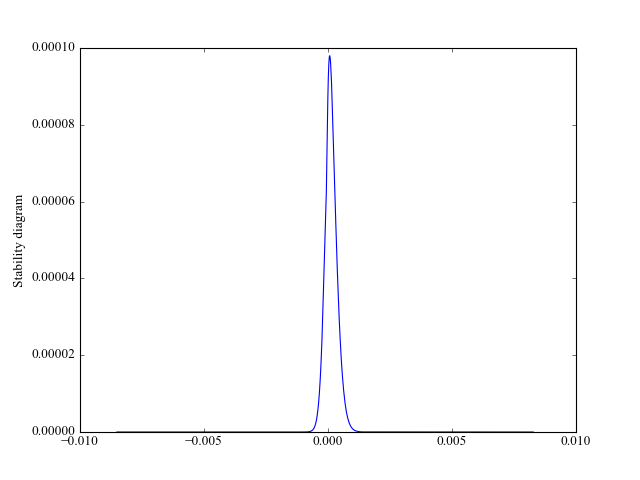

In [6]:
plt.close('all')
plt.plot(stab[0],stab[1])
plt.ylabel('Stability diagram')
plt.show()